In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import db_dtypes

In [2]:
client = bigquery.Client(project='first-project-321219')

query = """
WITH session_windows AS (
    -- Step 1: Define the start and end of every session
    SELECT 
        session_id,
        user_id,
        MIN(created_at) AS session_start,
        MAX(created_at) AS session_end
    FROM `bigquery-public-data.thelook_ecommerce.events`
    WHERE created_at >= '2022-01-01'
    GROUP BY 1, 2
),
order_totals AS (
    -- Step 2: Get total value for every order
    SELECT 
        user_id,
        order_id,
        created_at,
        SUM(sale_price) AS total_value
    FROM `bigquery-public-data.thelook_ecommerce.order_items`
    GROUP BY 1, 2, 3
)

SELECT 
    sw.session_id,
    sw.user_id,
    u.age,
    u.gender,
    u.country,
    u.traffic_source,
    sw.session_start,

    -- FEATURE: Total spend BEFORE this session started
    COALESCE((
        SELECT SUM(ot.total_value)
        FROM order_totals ot
        WHERE ot.user_id = sw.user_id 
          AND ot.created_at < sw.session_start
    ), 0) AS past_total_spend_before_session,

    -- FEATURE: Session count prior to this one
    COUNT(*) OVER (
        PARTITION BY sw.user_id 
        ORDER BY sw.session_start 
        ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ) AS number_of_prior_session_count,

    -- TARGET: Total spend WITHIN this session
    -- We look for orders by this user that happened between the session start and end
    COALESCE((
        SELECT SUM(ot.total_value)
        FROM order_totals ot
        WHERE ot.user_id = sw.user_id 
          AND ot.created_at BETWEEN sw.session_start AND sw.session_end
    ), 0) AS label_session_spend

FROM session_windows sw
JOIN `bigquery-public-data.thelook_ecommerce.users` u ON sw.user_id = u.id
ORDER BY sw.user_id, sw.session_start
"""

df = client.query(query).to_dataframe()
print(df.head())

                             session_id  user_id  age gender        country  \
0  53f4212d-da3c-413c-8009-2c362540df67        1   26      F  United States   
1  d815acfc-2672-4c85-9aad-a49a5cd1c7a8        2   17      M          Japan   
2  142f1d03-18e6-45c5-b351-b18bdd1b6c8e        3   16      M      Australia   
3  4306846f-3ded-43aa-ab67-ae1458315303        3   16      M      Australia   
4  7bfd934f-edbd-4568-981a-4af43be5bed0        4   69      F         Brasil   

  traffic_source             session_start  past_total_spend_before_session  \
0         Search 2024-09-08 16:47:28+00:00                              0.0   
1         Search 2024-12-13 22:06:40+00:00                              0.0   
2         Search 2024-11-21 13:19:14+00:00                              0.0   
3         Search 2024-11-21 14:26:51+00:00                              0.0   
4        Organic 2023-12-05 06:41:13+00:00                              0.0   

   number_of_prior_session_count  label_session_sp

In [3]:
def load_data(dataframe, datefrom = None, dateto = None):
    
    if not isinstance(dataframe, pd.DataFrame):   #isinstance(): check specified object is in specificed type.
        print('Error: Input is not a DataFrame')
        return None
  

    if 'label_session_spend' not in dataframe.columns: 
        print(f'Column Error: label_total_spend is not in DataFrame')
        return dataframe
        
    try:
        dataframe['session_start'] = pd.to_datetime(dataframe['session_start'])
    except Exception:
        print(f'Date Conversion Error: {Exception}')

    return dataframe

    

In [4]:
df_raw = load_data(df)
df_raw.head()

,session_id,user_id,age,gender,country,traffic_source,session_start,past_total_spend_before_session,number_of_prior_session_count,label_session_spend
0,53f4212d-da3c-413c-8009-2c362540df67,1,26,F,United States,Search,2024-09-08 16:47:28+00:00,0.0,0,0.000000
1,d815acfc-2672-4c85-9aad-a49a5cd1c7a8,2,17,M,Japan,Search,2024-12-13 22:06:40+00:00,0.0,0,0.000000
2,142f1d03-18e6-45c5-b351-b18bdd1b6c8e,3,16,M,Australia,Search,2024-11-21 13:19:14+00:00,0.0,0,189.949997
3,4306846f-3ded-43aa-ab67-ae1458315303,3,16,M,Australia,Search,2024-11-21 14:26:51+00:00,0.0,1,449.939987
4,7bfd934f-edbd-4568-981a-4af43be5bed0,4,69,F,Brasil,Organic,2023-12-05 06:41:13+00:00,0.0,0,0.000000


In [5]:
def prepare_data(df_input, target = 'label_session_spend'):

    df_input['day_num'] = df_input['session_start'].dt.weekday
    df_input['is_weekend']= (df_input['day_num'] >=5).astype(int)

    df_input['country'] = df_input['country'].replace(
                                            {'España': 'Spain', 
                                             'Deutschland': 'Germany'},regex = False)

    df_proc = df_input.copy()
    df_proc = df_proc.drop(['session_id', 'user_id', 'session_start','day_num'], axis = 1)
                            
    # cols_obj = df_proc.select_dtypes(include=['O']).columns.tolist()

    # df_getdum = pd.get_dummies(df_proc, columns = cols_obj, drop_first = True, dtype = int)

    #Reorder columns: put target at the end
    # if target in df_getdum.columns:
    #     cols = [c for c in df_getdum.columns if c not in target]
    #     df_getdum = df_getdum[cols + [target]]

    return df_proc
    
    

In [6]:
df_prepare = prepare_data(df_raw)
df_prepare

,age,gender,country,traffic_source,past_total_spend_before_session,number_of_prior_session_count,label_session_spend,is_weekend
0,26,F,United States,Search,0.000000,0,0.000000,1
1,17,M,Japan,Search,0.000000,0,0.000000,0
2,16,M,Australia,Search,0.000000,0,189.949997,0
3,16,M,Australia,Search,0.000000,1,449.939987,0
4,69,F,Brasil,Organic,0.000000,0,0.000000,0
...,...,...,...,...,...,...,...,...
162893,54,F,United States,Facebook,108.979998,3,69.949997,1
162894,54,F,United States,Facebook,199.879995,4,46.000000,1
162895,54,F,United States,Facebook,199.879995,5,105.980000,1
162896,54,F,United States,Facebook,199.879995,6,81.990000,1


In [7]:
# pip install --user xgboost

In [8]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV


def xgboost(df, target = 'label_session_spend', test_size = 0.2, random_state = 16):
    
    X = df.drop(['label_session_spend'], axis=1)
    
    # Change object data to category
    cat_col = X.select_dtypes(exclude=np.number).columns.tolist()

    for col in cat_col:
        X[col] = X[col].astype('category')

    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

    # 1) RandomisedSearchCV: find the best params
    # XGBoost can be done by native API of XGBoost that comes with its own class for storing datasets (DMatrix) or Scikit-learn API. 
    # We want to find the best params by using RandomizedSearchCV. Therefore, we use Scikit-learn API.

    # When I used native XGBoost API, I get RMSE is: 88.415 at 9999 round. but in cross validation is 82.54936238489479. 
    
    param_grid ={
            'max_depth': [3,5,7],
            'learning_rate': [0.01, 0.05, 0.1], #how much we trust for each tree? e.g. 0.01 per tree then we need more trees (n_estimators)
            'subsample': [0.7, 0.8, 0.9], # extract certrain pct rows/sample in each tree. e.g. 0.8 means taking 80% data per tree. it can avoid several datapoints.
            'colsample_bytree': [0.7, 0.8, 0.9],  # extract certain pct of features/columns
            'n_estimators': [500, 1000]
        }

    xgbr = xgb.XGBRegressor(tree_method='hist', enable_categorical=True, objective = 'reg:squarederror')  # objective: do regression model and aim for min rmse

    search = RandomizedSearchCV(
                                estimator = xgbr,  # find xgboost params
                                param_distributions = param_grid,  # input the params we want to find
                                n_iter = 10,  # we only take 10 groups to find the best praams
                                cv = 5,  # cross validation
                                scoring ='neg_root_mean_squared_error',  # aim for min RMSE. sklearn gets used to higher score is better. so we add minor
                                random_state = random_state,
                                n_jobs=-1) #use all CPU 
    search.fit(X_train, y_train)

    best_params = search.best_params_

    print(f'Best Params: {best_params}')

    # 2) use the best params to train the model

    model = xgb.XGBRegressor(**best_params, tree_method='hist', enable_categorical=True, objective = 'reg:squarederror')

    model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
            )

    # predict
    preds = model.predict(X_test)

    # native XGBoost API 
    # dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical = True)
    # dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical = True)

    # # specify hyperparameters in a dictionary
    # params = {'objective': 'reg:squarederror', 'tree_method': 'hist'}

    # # train model
    # n =10000

    # evals = [(dtest_reg, 'validation'), (dtrain_reg, 'train')]
    
    # model = xgb.train(
    #     params = params,
    #     dtrain = dtrain_reg,
    #     num_boost_round=n,
    #     evals = evals,
    #     verbose_eval=1000, #show evaluation evey 1000 rounds
    #     early_stopping_rounds = 50
    # )

    # predict
    # preds = model.predict(X_test)
    
    # evaluate performance
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, preds)
    print(f'RMSE is: {rmse:.3f}')
    print(f'R_squared: {r2:.3f}')

    #cross validation
    
    # results = xgb.cv(
    #         params = params,
    #         dtrain = dtrain_reg,
    #         num_boost_round=n,
    #         nfold=5,
    #         early_stopping_rounds=20
    #         )

    # print('\ncross validation:\n', results.head())

    # best_rmse = results['test-rmse-mean'].min()
    # print('best_rmse: ', best_rmse)

    # return the feature's importance

    importance = pd.DataFrame({
                    'feature': X.columns,
                    'importance': model.feature_importances_
                    }).sort_values(by='importance', ascending = False)
    
    plt.scatter(y_test, preds)
    plt.show()
    
    return model, y_test, preds, importance

Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
RMSE is: 82.498
R_squared: 0.153


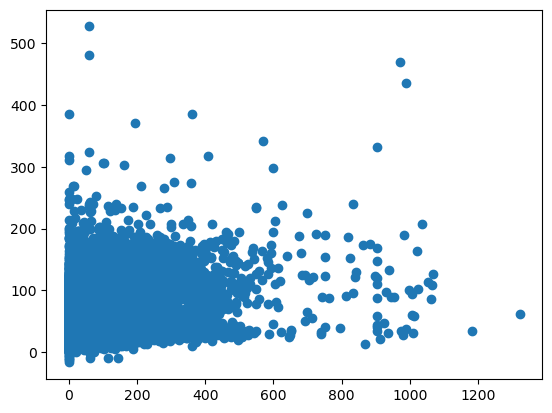

In [9]:
model, y_actual, y_preds, feature_importance = xgboost(df_prepare)
# R square is low: it might have outliers. or session spend isn't a simple linear relationship. or the model didn't have key features.

In [10]:
feature_importance

,feature,importance
5,number_of_prior_session_count,0.409897
4,past_total_spend_before_session,0.175054
1,gender,0.095948
2,country,0.084977
0,age,0.082289
3,traffic_source,0.077176
6,is_weekend,0.074658
